In [1]:
import datetime
import pyaurorax
import matplotlib.pyplot as plt

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools
at.set_theme("dark")

# Create TREx Spectrograph keogram

Below, we"ll work through the creation of a 1 hour keogram created from TREx Spectrograph data, for various emissions wavelengths.

In [2]:
# download an hour of TREx Spectrograph data
dataset_name = "TREX_SPECT_PROCESSED_V1"
start_dt = datetime.datetime(2021, 2, 16, 9, 0)
end_dt = datetime.datetime(2021, 2, 16, 9, 59)
site_uid = "rabb"
r = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)

In [3]:
# read in the data
data = aurorax.data.ucalgary.read(r.dataset, r.filenames, n_parallel=5)

## Generate keogram

Making a keogram for the spectrograph data is a bit different to ASIs because of the nature of the instrument. Instead of taking the middle slice of each image and stacking them horizontally, we specify the wavelength which works as the middle slice. 

In [4]:
# create the keogram
#
# NOTE: if no emission is specified, the function defaults to the
# greenline emission (557.7 nm) for spectrograph data.
keogram = at.keogram.create(data.data, data.timestamp, spectra=True, wavelength=data.metadata[0]["wavelength"])

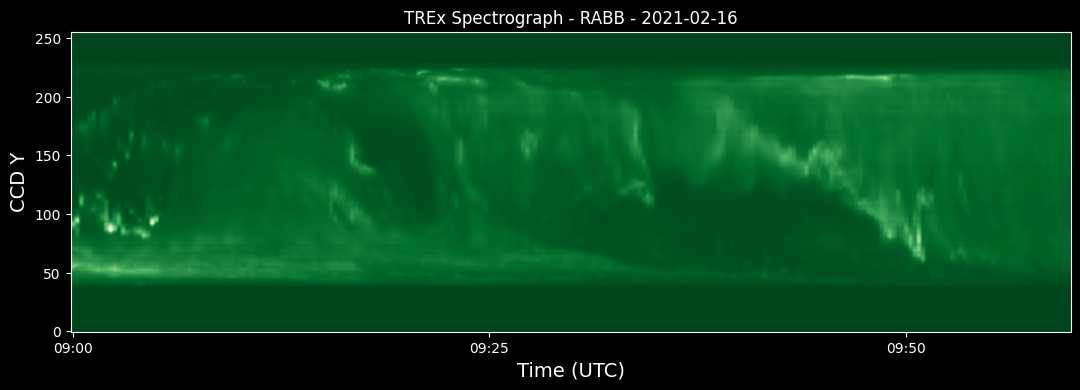

In [5]:
# plot the keogram
keogram.plot(
    figsize=(10, 3),
    aspect="auto",
    cmap="Greens_r",
    title=f"TREx Spectrograph - {site_uid.upper()} - {start_dt.date()}",
)

## Keograms for various wavelengths

Now let"s make four keograms, one for each of the available spect_emission options. 

To look at emissions that are not included, wavelength integration ranges for emissions and background subtraction can be passed using the spect_band and spect_band_bg parameters.


In [6]:
# pull out the data to be used for all keograms
data_arr = data.data
timestamps = data.timestamp
wavelengths = data.metadata[0]["wavelength"]

# create the keograms for each emission
keogram_hbeta = at.keogram.create(data_arr, timestamps, spectra=True, wavelength=wavelengths, spect_emission="hbeta")
keogram_4278 = at.keogram.create(data_arr, timestamps, spectra=True, wavelength=wavelengths, spect_emission="blue")
keogram_5577 = at.keogram.create(data_arr, timestamps, spectra=True, wavelength=wavelengths, spect_emission="green")
keogram_6300 = at.keogram.create(data_arr, timestamps, spectra=True, wavelength=wavelengths, spect_emission="red")

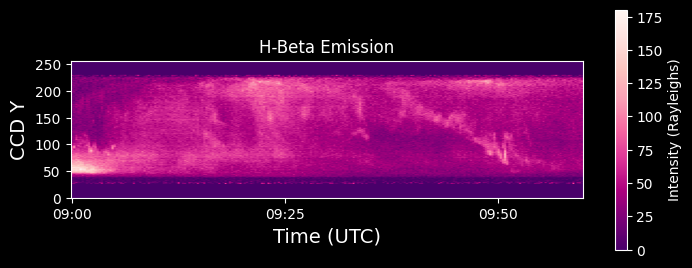

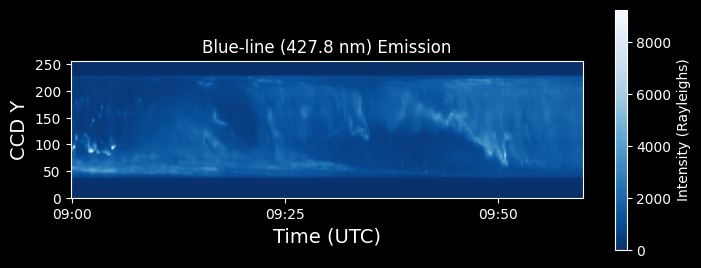

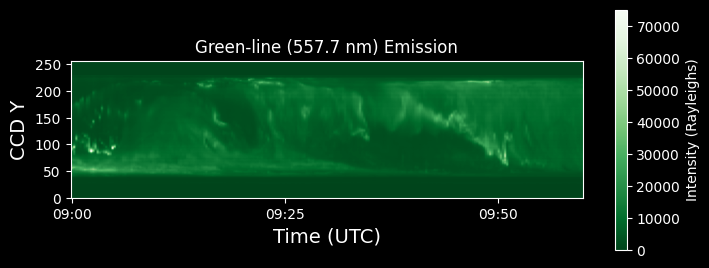

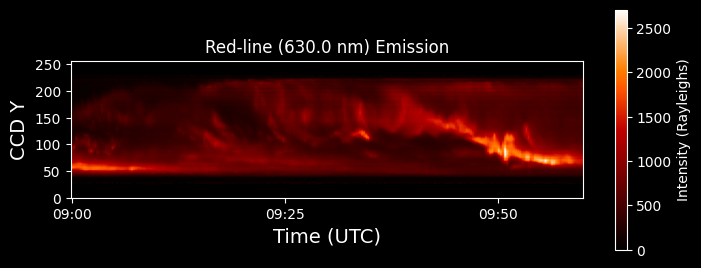

In [7]:
# plot all four keograms, we will use returnfig option to create a figure and axis, so that we can add colorbars
fig, ax = keogram_hbeta.plot(cmap="RdPu_r", title=f"H-Beta Emission", aspect=0.25, returnfig=True)
colorbar = fig.colorbar(ax.images[0], ax=ax, shrink=0.5, label="Intensity (Rayleighs)")

fig, ax = keogram_4278.plot(cmap="Blues_r", title=f"Blue-line (427.8 nm) Emission", aspect=0.25, returnfig=True)
colorbar = fig.colorbar(ax.images[0], ax=ax, shrink=0.5, label="Intensity (Rayleighs)")

fig, ax = keogram_5577.plot(cmap="Greens_r", title=f"Green-line (557.7 nm) Emission", aspect=0.25, returnfig=True)
colorbar = fig.colorbar(ax.images[0], ax=ax, shrink=0.5, label="Intensity (Rayleighs)")

fig, ax = keogram_6300.plot(cmap="gist_heat", title=f"Red-line (630.0 nm) Emission", aspect=0.25, returnfig=True)
colorbar = fig.colorbar(ax.images[0], ax=ax, shrink=0.5, label="Intensity (Rayleighs)")


### **Note: Scaling Spectrograph Keograms**

Spectrograph data can be scaled for visual purposes, just like all-sky image data. However, caution must be taken...

1. You must scale the spectrograph data ***AFTER*** creating the keogram. When at.keogram.create() is called with the keyword spectra=True, the spectra are being integrated within this function to obtain whichever emission (e.g. greenline) is specified. To preserve physical units, the integration must be performed first, and then the Rayleighs values can be scaled afterwards for visualization

2. You must remember that you are scaling physical units. Thus, a colorbar is warranted, in order to demonstrate what the brightness of pixels in the keogram image *truly* mean

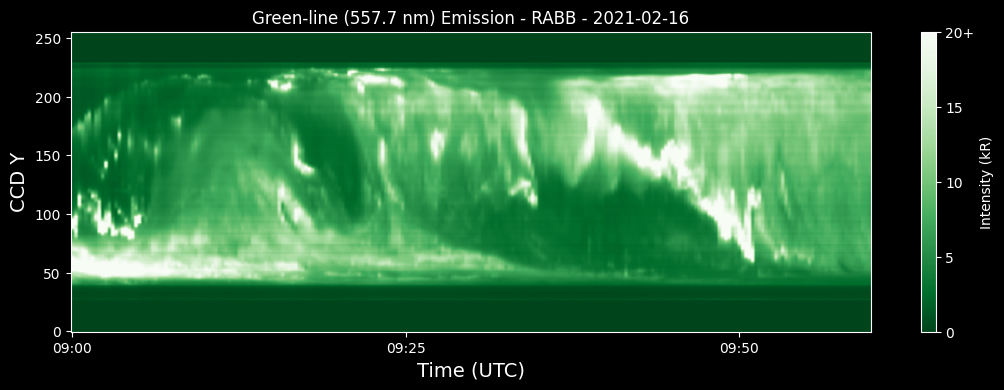

In [8]:
import numpy as np



# Create the lone 557.7 nm keogram again, this time using scaled data
keogram = at.keogram.create(data.data, data.timestamp, spectra=True, wavelength=data.metadata[0]["wavelength"])

# Scale the integrated data inside the keogram (which is now in units of Rayleighs).
# For this example we scale between 0 and 20 kR
keogram.data = at.scale_intensity(keogram.data, min=0, max=20000, top=20000)

# Plot the keogram
fig, ax = keogram.plot(figsize=(10, 3), aspect="auto", cmap="Greens_r", title=f"Green-line (557.7 nm) Emission - {site_uid.upper()} - {start_dt.date()}", returnfig=True)

# Create a colorbar, and manually set ticks... this will help up edit the colorbar so it accounts for the scaling we did
# Maybe we'd also like the colorbar to be in units of kR instead of R... we can handle this as well
colorbar = fig.colorbar(ax.images[0], ax=ax, label="Intensity (kR)", ticks=[1,5000,10000,15000,20000])

# Manually set the tick labels based on what we've scaled to (and in kR)
# We include a '+' on the max scaling bound as any data that was above 20,000 will be
# scaled to the same color in the image
colorbar.ax.set_yticklabels(['0','5','10','15','20+'])
plt.show()

## **Reference in geographic coordinates**

For each camera, the UCalgary maintains a geospatial calibration dataset that maps pixel coordinates (detector X and Y) to local observer and geodetic coordinates (at altitudes of interest). We refer to this calibration as a 'skymap'. The skymaps may change due to the freeze-thaw cycle and changes in the building, or when the instrument is serviced. A skymap is valid for a range of dates. The metadata contained in a file includes the start and end dates of the period of its validity.

Be sure you choose the correct skymap for your data timeframe. The `download_best_skymap()` function is there to help you, but for maximum flexibility you can download a range of skymap files and use whichever you prefer. All skymaps can be viewed by looking at the data tree for the imager you are using (see https://data.phys.ucalgary.ca/), or using the PyAuroraX `get_urls()` or `download()` functions. If you believe the geospatial calibration may be incorrect, please contact the UCalgary team.

For more on the skymap files, please see [the skymap file description document](https://data.phys.ucalgary.ca/sort_by_project/other/documentation/skymap_file_description.pdf).

In [9]:
# download skymap file
r = aurorax.data.ucalgary.download_best_skymap("TREX_SPECT_SKYMAP_IDLSAV", site_uid, start_dt)
skymap_data = aurorax.data.ucalgary.read(r.dataset, r.filenames).data[0]

In [10]:
# Set the geographic latitudes for the keogram
keogram.set_geographic_latitudes(skymap_data)

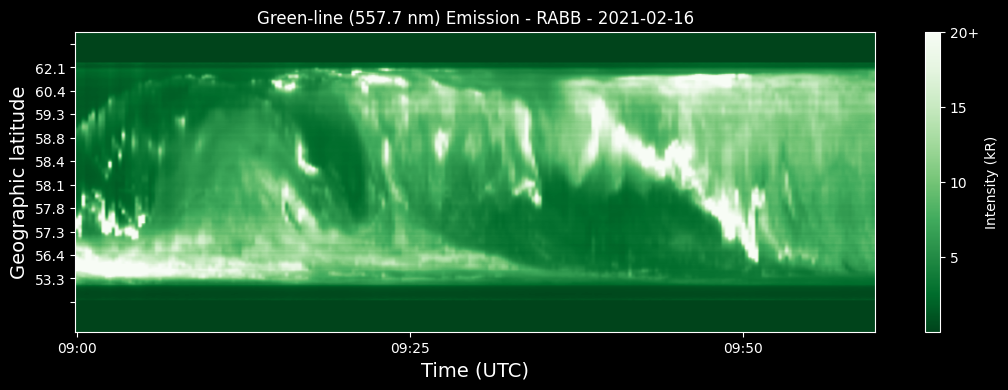

In [11]:
# Create keogram, **this time using geographic latitudes for the y-axis**
#                      \/ \/ \/ \/
fig, ax = keogram.plot(y_type='geo',
                       figsize=(10, 3),
                       aspect="auto",
                       cmap="Greens_r",
                       title=f"Green-line (557.7 nm) Emission - {site_uid.upper()} - {start_dt.date()}",
                       returnfig=True,
                       ytick_increment=20)

# Add our same colorbar since we're still working with the scaled keogram
colorbar = fig.colorbar(ax.images[0], ax=ax, label="Intensity (kR)", ticks=[0,5000,10000,15000,20000])
colorbar.ax.set_yticklabels(['0','5','10','15','20+'])
plt.show()

## **Reference in magnetic coordinates**

Leveraging AACGM, we can also display the keogram using magnetic latitudes.

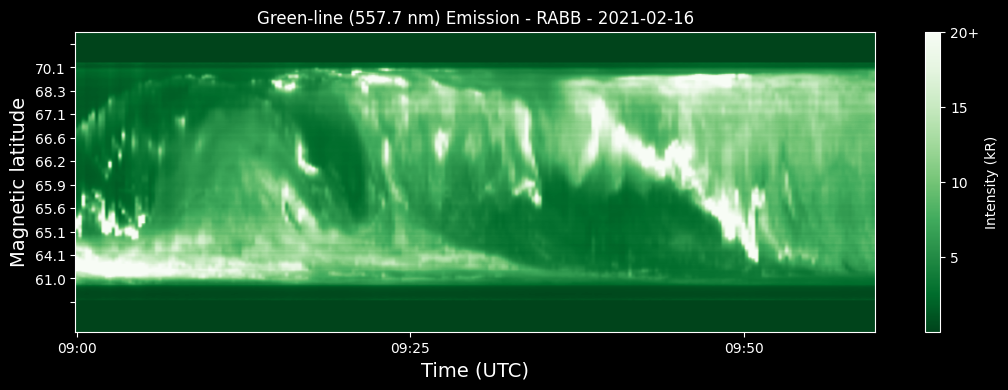

In [12]:
# set the magnetic latitudes for the keogram
keogram.set_magnetic_latitudes(skymap_data, start_dt)

# Create keogram, **this time using magnetic latitudes for the y-axis**
#                      \/ \/ \/ \/
fig, ax = keogram.plot(y_type='mag',
                       figsize=(10, 3),
                       aspect="auto",
                       cmap="Greens_r",
                       title=f"Green-line (557.7 nm) Emission - {site_uid.upper()} - {start_dt.date()}",
                       returnfig=True,
                       ytick_increment=20)

# Add our same colorbar since we're still working with the scaled keogram
colorbar = fig.colorbar(ax.images[0], ax=ax, label="Intensity (kR)", ticks=[0,5000,10000,15000,20000])
colorbar.ax.set_yticklabels(['0','5','10','15','20+'])
plt.show()